In [1]:
import urllib
import os
import pathlib
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [2]:
# set data root for all relative paths
DATA_ROOT = './data/'
FIGURES_ROOT = './figures/'

### Download tutorial datasources

In [3]:
# create list of URLs for data download locations
url_list = [
    'http://bostonopendata-boston.opendata.arcgis.com/datasets/b6bffcace320448d96bb84eabb8a075f_0.csv',
    'https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/695a8596-5458-442b'\
    '-a017-7cd72471aade/download/fy19fullpropassess.csv',
    'http://bostonopendata-boston.opendata.arcgis.com/datasets/53ea466a189b4f43b3dfb7b38fa7f3b6_1.zip'
]

# create list of filenames (without extensions) for renaming direct URL files
name_list = ['SAMaddresses', 'FY19_propassessments', 'ZIPshapefiles']

# generate lists for original filenames, new filenames, and target new filepaths
orig_filename_list = [os.path.basename(url) for url in url_list]
filename_list = [
    ''.join([name, os.path.splitext(orig_filename)[1]]) for name, orig_filename in zip(
        name_list,
        orig_filename_list
    )
]
filepath_list = [
    os.path.join(DATA_ROOT, filename) for filename in filename_list
]

# report on lists
print(orig_filename_list)
print(filename_list)
print(filepath_list)

['b6bffcace320448d96bb84eabb8a075f_0.csv', 'fy19fullpropassess.csv', '53ea466a189b4f43b3dfb7b38fa7f3b6_1.zip']
['SAMaddresses.csv', 'FY19_propassessments.csv', 'ZIPshapefiles.zip']
['./data/SAMaddresses.csv', './data/FY19_propassessments.csv', './data/ZIPshapefiles.zip']


In [4]:
# create list of current top-level files and directories
directories = os.listdir('.')

# check for ./data/ dir and create if it doesn't exist
if not os.path.dirname(DATA_ROOT)[2:] in directories:
    os.mkdir(DATA_ROOT)

# also check for ./figures/ dir and create if it doesn't exist
if not os.path.dirname(FIGURES_ROOT)[2:] in directories:
    os.mkdir(FIGURES_ROOT)

# create list of files currently present in DATA_ROOT
files = os.listdir(DATA_ROOT)

# download data files if they do not already exist
for filepath, filename, url in zip(filepath_list, filename_list, url_list):
    if not filename in files:
        local_filename, headers = urllib.request.urlretrieve(
            url,
            filepath
        )

# confirm list of new files in DATA_ROOT
files = os.listdir(DATA_ROOT)

# report on files
print(files)

['.gitkeep', 'FY19_propassessments.csv', 'SAMaddresses.csv', 'ZIPshapefiles.zip', 'ZIP_Codes.cpg', 'ZIP_Codes.dbf', 'ZIP_Codes.prj', 'ZIP_Codes.shp', 'ZIP_Codes.shx']


### Unzip downloaded shapefiles archive

In [5]:
# load mc_enhance csv data directly from zip archive using zipfile
with zipfile.ZipFile(filepath_list[2], 'r') as zipobj:
    
    # report on contents of zip archive
    print("This zip archive contains the following files: {0}\n".format(zipobj.namelist()))
    
    # extract all files
    zipobj.extractall(DATA_ROOT)

# confirm extracted datafiles
files = os.listdir(DATA_ROOT)
print(files)

# save filepath for newly extracted .shp file
filepath_shape = os.path.join(DATA_ROOT, 'ZIP_Codes.shp') 

This zip archive contains the following files: ['ZIP_Codes.prj', 'ZIP_Codes.shp', 'ZIP_Codes.cpg', 'ZIP_Codes.shx', 'ZIP_Codes.dbf']

['.gitkeep', 'FY19_propassessments.csv', 'SAMaddresses.csv', 'ZIPshapefiles.zip', 'ZIP_Codes.cpg', 'ZIP_Codes.dbf', 'ZIP_Codes.prj', 'ZIP_Codes.shp', 'ZIP_Codes.shx']


### Read data and begin tutorial

In [6]:
# Read in SAM and property assessment dataframes from saved CSV files
df_sam = pd.read_csv(filepath_list[0], dtype=str)
df_prop = pd.read_csv(filepath_list[1], dtype=str)

# Convert 'X' and 'Y' (i.e. lat/lon) values in SAM dataframe to floats 
df_sam['X'] = df_sam['X'].astype(float)
df_sam['Y'] = df_sam['Y'].astype(float)

In [7]:
# set the filepath and load in a shapefile using Geopandas
zipshape_df = gpd.read_file(filepath_shape)

# check data type so we can see that this is a "GEO" dataframe
# check shape and return head to see values
print(type(zipshape_df))
print()
print(zipshape_df.shape)
print()
zipshape_df.head()

<class 'geopandas.geodataframe.GeoDataFrame'>

(43, 5)



,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...


### Basic Geopandas Plotting

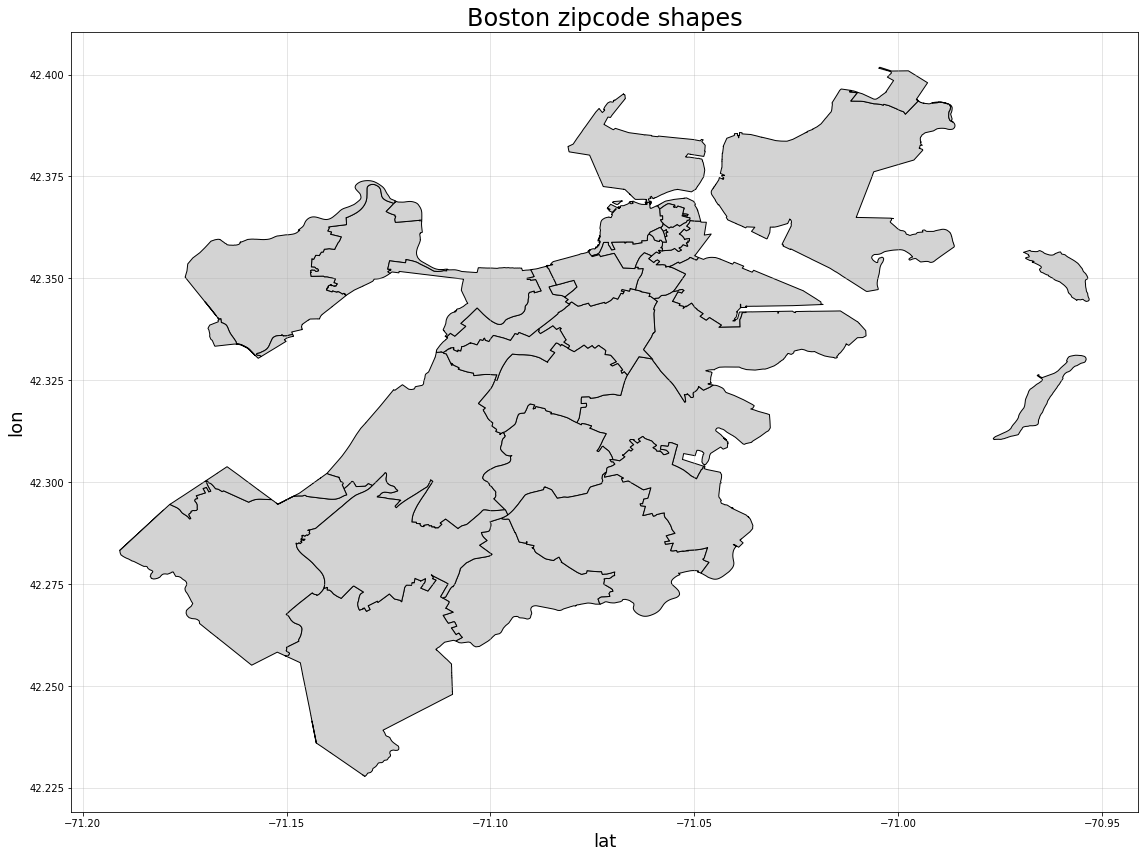

In [8]:
# plot basic shapefile polygons to lat/lon grid using Geopandas .plot() method
# coupled with basic matplotlib pyplot features/methods

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes',
    fontsize=24
)

# note that the geopandas dataframe object, has a .plot() method for easy plotting
zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k')

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

In [9]:
# To label each shape, we first need to find a "representative point" for each polygon geometry
# shapely (built into geopandas) can handle this with the representative_point() method

zipshape_df['coords'] = zipshape_df['geometry'].apply(lambda x: x.representative_point().coords[:])
zipshape_df['coords'] = [coords[0] for coords in zipshape_df['coords']]

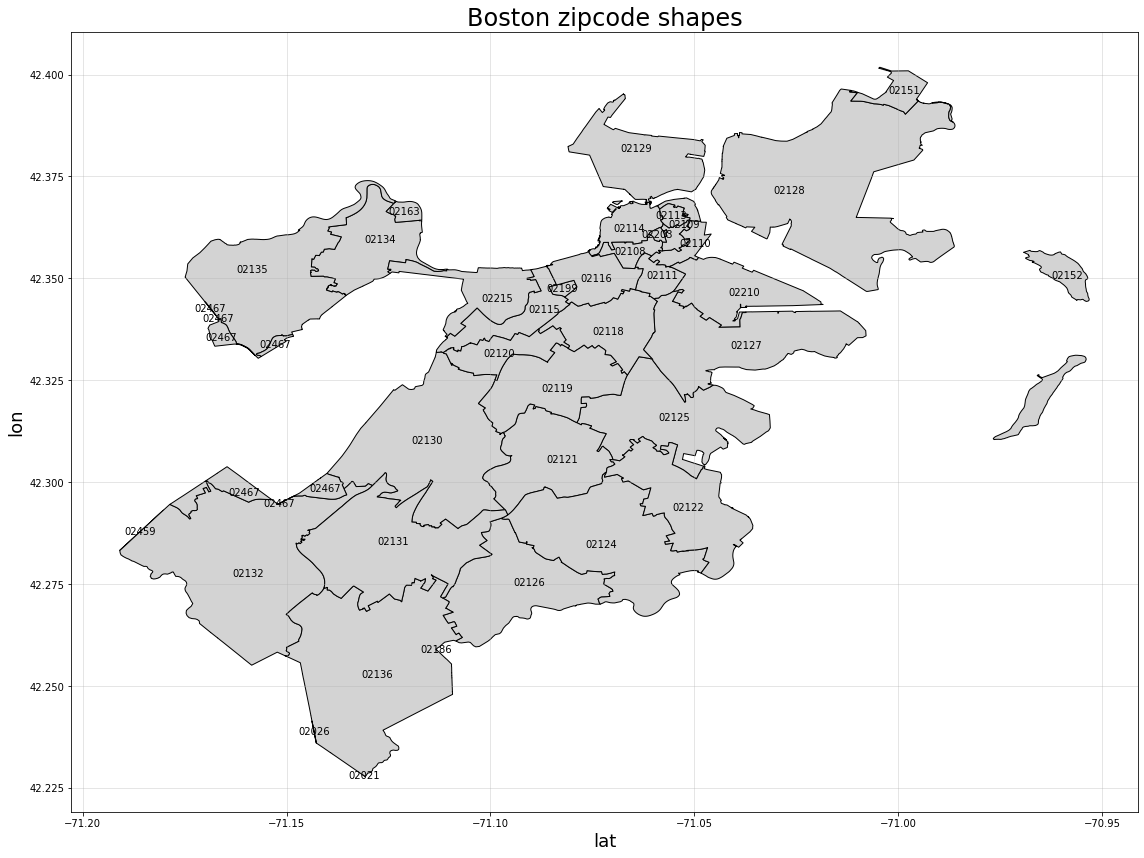

In [10]:
# and then using matplotlib's annotate() method, we can print zip5 values to our map

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes',
    fontsize=24
)

zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k')

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

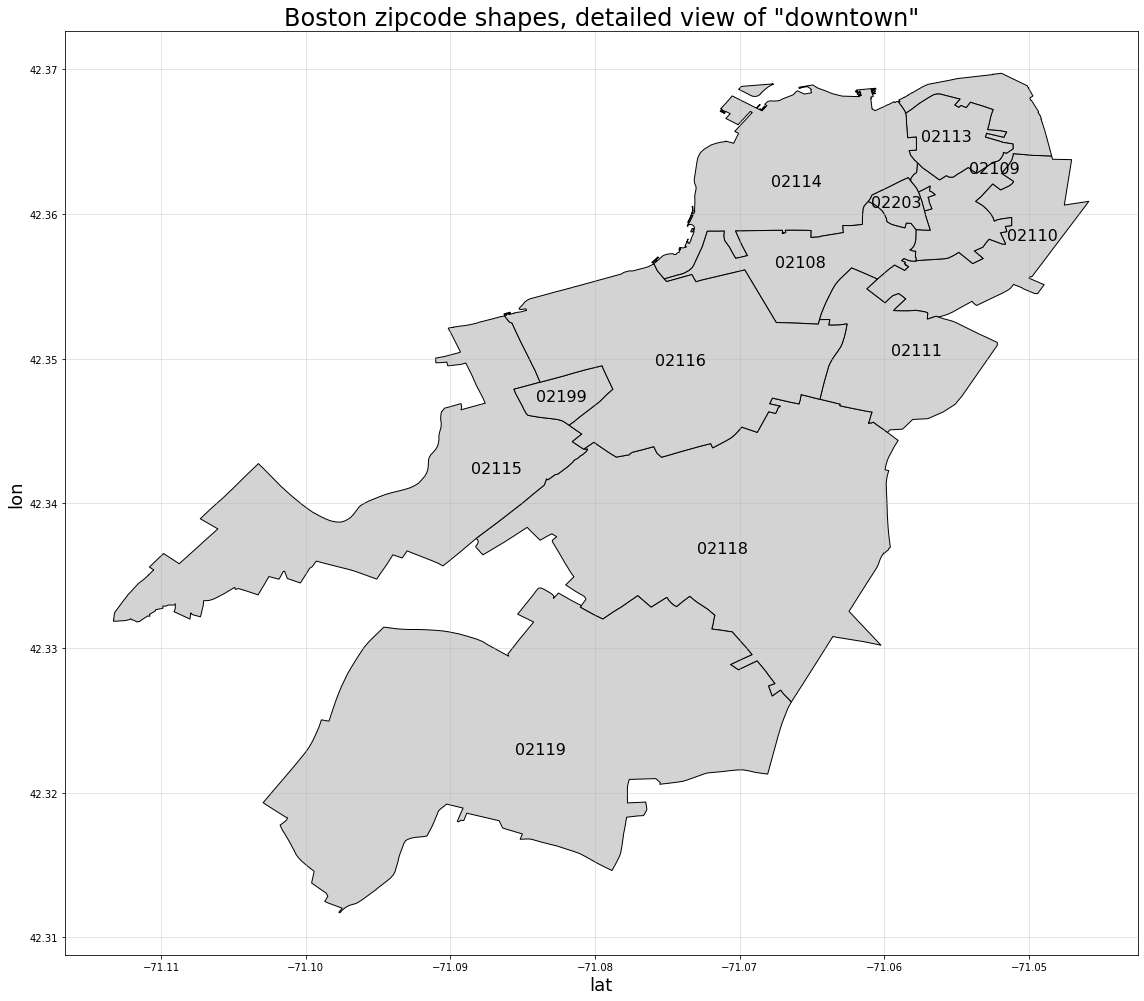

In [11]:
# and then using .loc[] we can subset our geopandas dataframe to plot only
# a subset of our zipcodes, perhaps to zoom in and make the downtown zipcodes easier to see

loc = (
    (zipshape_df['ZIP5'].str.contains('0211')) |
    (zipshape_df['ZIP5'].str.contains('0210')) |
    (zipshape_df['ZIP5'] == '02199') |
    (zipshape_df['ZIP5'] == '02203')
)

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes, detailed view of "downtown"',
    fontsize=24
)

zipshape_df.loc[loc].plot(ax=ax, color='lightgray', edgecolor='k')

for idx, row in zipshape_df.loc[loc].iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

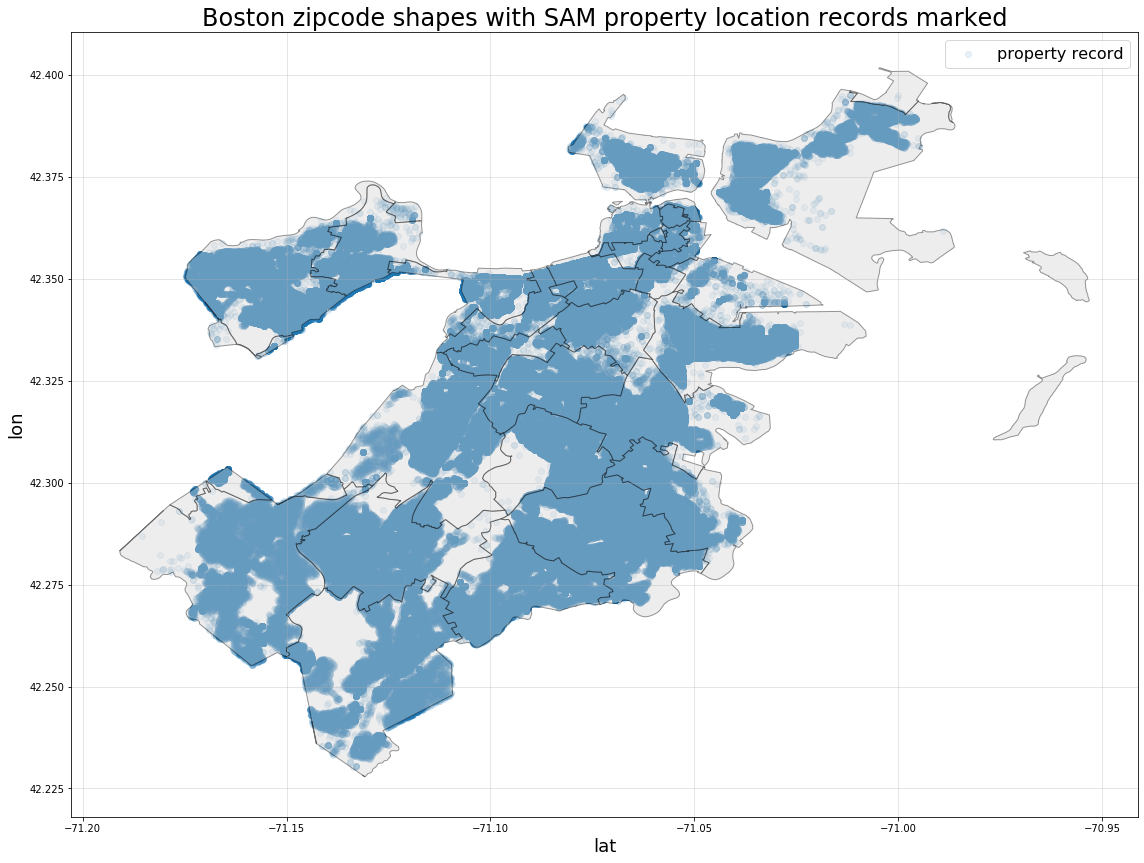

In [12]:
# using basic matplotlib plotting funtions, we can also layer our datapoints along with the shapes 
fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Boston zipcode shapes with SAM property location records marked',
    fontsize=24
)

plt.scatter(df_sam['X'], df_sam['Y'], alpha=0.1, label='property record')

zipshape_df.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)


plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show();

In [13]:
# now to create a summary table from the SAM addresses for visuallizing
# property records density by ZIP using our shapefile for aggregation

# first create summary count data by unique ZIP
prop_count_by_zip = df_sam.groupby('ZIP_CODE').agg(
    {'ZIP_CODE':'count'}
).rename({'ZIP_CODE': 'properties'}, axis=1)

print(prop_count_by_zip.shape)
prop_count_by_zip.head()

(37, 1)


,properties
ZIP_CODE,
02026,1
02108,4366
02109,4392
02110,3555
02111,6092


In [14]:
# Next we merge our count data with our shapefile polygon geometries dataframe
zipcode_prop_df = zipshape_df.join(prop_count_by_zip, on='ZIP5')

print(zipcode_prop_df.shape)
print()
print(
    'Property-counts-per-zip summary stats\n{}'.format(
    zipcode_prop_df['properties'].describe()
    )
)
zipcode_prop_df.head()

(43, 7)

Property-counts-per-zip summary stats
count       38.000000
mean     10621.289474
std       8877.289396
min          1.000000
25%        921.000000
50%      11822.500000
75%      15472.000000
max      30072.000000
Name: properties, dtype: float64


,OBJECTID,ZIP5,ShapeSTAre,ShapeSTLen,geometry,coords,properties
0,1,02134,3.721936e+07,40794.182396,POLYGON ((-71.12340461235522 42.36420867214283...,"(-71.12704824441153, 42.35944218076044)",14644.0
1,2,02125,6.476052e+07,62224.521440,POLYGON ((-71.04541458491363 42.32380666715233...,"(-71.05487618131991, 42.31578366454911)",19400.0
2,3,02110,6.637284e+06,18358.213496,POLYGON ((-71.05109058896998 42.36418367507441...,"(-71.04976610342825, 42.35849650724344)",3555.0
3,4,02118,3.116158e+07,32353.407618,POLYGON ((-71.06315159137533 42.34688867055895...,"(-71.07117288285457, 42.33688916926195)",19608.0
4,5,02126,6.078585e+07,45488.394711,POLYGON ((-71.09669659978795 42.29095065982932...,"(-71.09036847374043, 42.275358656948306)",14376.0


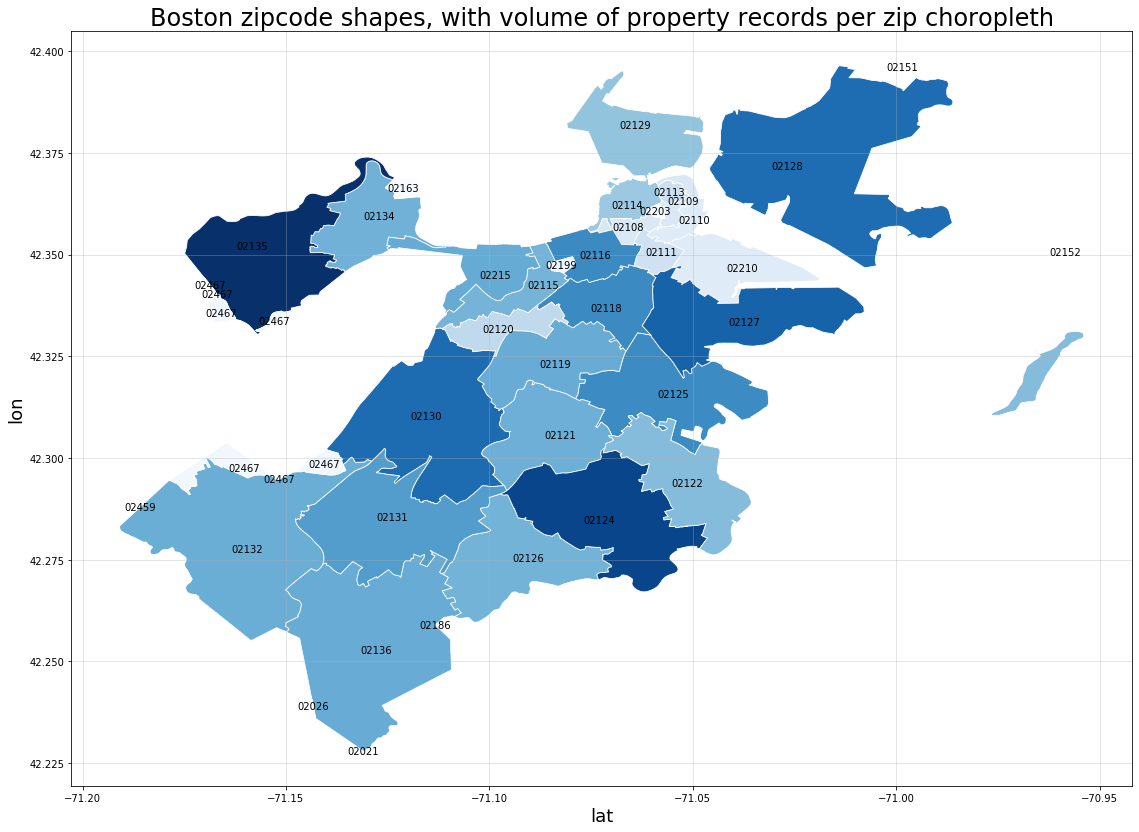

In [15]:
# identify the variable column name we're using
variable = 'properties'

# plot results
fig, ax = plt.subplots(figsize=(16,16))

plt.title(
    'Boston zipcode shapes, with volume of property records per zip choropleth',
    fontsize=24
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
zipcode_prop_df.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

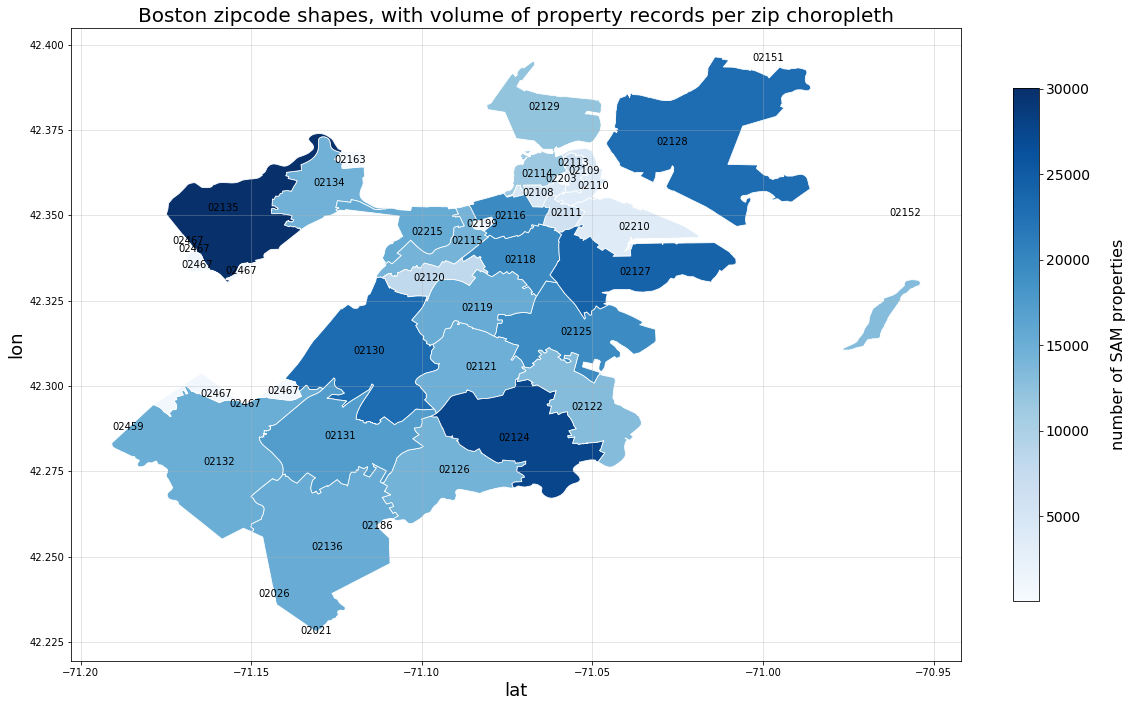

In [16]:
# Now to add a colorbar for better interpretability of our choropleth plot

variable = 'properties'

# set min and max variable values for use in plotting our colorbar
vmin = zipcode_prop_df[variable].describe()['min']
vmax = zipcode_prop_df[variable].describe()['max']

fig, ax = plt.subplots(figsize=(16,10))

plt.title(
    'Boston zipcode shapes, with volume of property records per zip choropleth',
    fontsize=20
)

# NOTE: null values must be dropped from our df (as is shown below).
#       Otherwise, the choropleth does not provide any gradation in color
zipcode_prop_df.dropna(subset=[variable]).plot(
    column=variable,
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='white'
)

# here we use the geopandas dataframe object's built-in iterrows() method
# to turn zipshape_df into a generator object for iteration
for idx, row in zipshape_df.iterrows():
    plt.annotate(
        s=row['ZIP5'],
        xy=row['coords'],
        horizontalalignment='center',
        verticalalignment='center'
    )
    
# here we create a colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# ...then we add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax, shrink=.8, fraction=0.1)

# ...and finally we format the colorbar for readability
cbar.set_label(label='\nnumber of SAM properties', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()

# save sample choropleth for showing in README.md
plt.savefig(os.path.join(FIGURES_ROOT, 'sample-choropleth.png'))
plt.show();